In [ ]:
!pip install import-ipynb

In [ ]:
from pathlib import Path
from utils import check_integrity, datestring_to_timestamp, load_data
import import_ipynb
import graph_generation
from graph_generation import MST, PMFG
import crypto_correlation
from crypto_correlation import calculate_cm, cm_pearson
import numpy as np
import pandas as pd

In [ ]:
def build_data_list_monthly(paths, start_time, end_time):
    # build interval from Jan - Oct
    interval = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]
  
    data_list = []
    name_list = []
    print(len(paths))
    
    for i in range(0, len(paths)):
        cryptocurrency_price_list = []
        
        cryptocurrency_df = load_data(start_time, end_time, paths[i], fill_na=True)
        
        #record the name of crytocurrency

        name_list.append(cryptocurrency_df.index[0][1])

        #discard other columns except close price
        close_price_df = cryptocurrency_df["close"]
    
        for j in range(0, len(interval)):
            if( j == 0):
                idx = idx = 0
                shift_idx = interval[0] - 1
            else:
                idx += interval[j - 1]
                shift_idx += interval[j]
            
            vector = close_price_df.iloc[idx:shift_idx + 1]
           
            #Calculate the price ratio of changing
            vector = vector.to_frame()
            vector = vector.pct_change().fillna(0)

            cryptocurrency_price_list.append(np.asarray(vector))
           
        data_list.append(cryptocurrency_price_list)  
        
    return data_list, name_list

In [220]:
import os

color_palette = ["#66c2a5","#fc8d62","#8da0cb","#e78ac3","#a6d854","#ffd92f","#e5c494","#b3b3b3", "#4e79a7","#f28e2c",
"#e15759","#76b7b2","#59a14f","#edc949","#af7aa1","#ff9da7","#9c755f","#bab0ab"]
def nw_plot(G, node_groups, title, save_path, g_type, map_pos):
    fig = plt.figure(figsize = (10,10))
    labels = nx.get_node_attributes(G, 'ticker')
    color_map = []
    for i in range(0, len(node_groups)):
        for node in G:
            if node in node_groups[i]:
                color_map.append(color_palette[i])
    if g_type == 'MST':
        plt.title('Minimal Spanning Tree - '+ title)
        save_suffix = title+"_MST.png"
    if g_type == 'PMFG':
        plt.title('Planar Maximally Filtered Graph  - '+ title)
        save_suffix = title+"_PMFG.png"
    nx.draw(G, pos=map_pos, with_labels=True, labels=labels,node_size=100,font_size=10,
    node_color=color_map, edge_color='lightgray', verticalalignment='bottom')
    #res = nx.draw(G,with_labels=True, labels=labels,node_size=100,font_size=10,
    #node_color=color_map, edge_color='lightgray')
    plt.savefig(os.path.join(save_path, save_suffix),dpi=300)


### Calculate the communities of large time scale : Jan 2021 - Nov 2021, monthly

In [204]:
# Calculate communities from Jan - Nov with the time scale of monthly

data_path = "../data"
start_from = "2020-12-01"
end_before = "2021-11-30"
interval = "1D"

start_from_timestamp = datestring_to_timestamp(start_from)
end_before_timestamp = datestring_to_timestamp(end_before)
data_1D_path_list = list(Path(data_path, interval).iterdir())

coins_1M_pass = []
for file_path in data_1D_path_list:
    _coin_code = file_path.name.split("_")[0]
    if check_integrity(start_from, end_before, file_path) is not None:
        coins_1M_pass.append(file_path)

# load csv and build list
crypto_data_list_monthly, name_list = build_data_list_monthly(coins_1M_pass, start_from_timestamp, end_before_timestamp)

# calculate correlation matrix

correlation_matrix_pearson = calculate_cm(crypto_data_list_monthly, cm_pearson)

print(len(crypto_data_list_monthly))
print(len(crypto_data_list_monthly[0]))
print(len(correlation_matrix_pearson))
print(correlation_matrix_pearson[0].shape)

#np.save('test.npy', crypto_data_list_monthly, allow_pickle=True)

68
68
11
11
(68, 68)


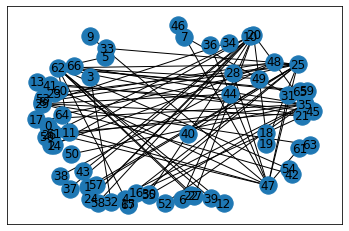

In [205]:
# Build MST or PMFG
mst_t = MST(correlation_matrix_pearson[0], True)

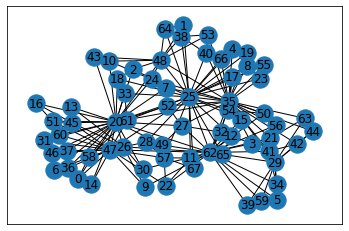

In [206]:
#PMFG 
pmfg_g = PMFG(correlation_matrix_pearson[0], True)

In [207]:
print(len(correlation_matrix_pearson))

11


In [ ]:
# Calculate 
import networkx as nx
from networkx.algorithms import community
from matplotlib import pyplot as plt

title = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'Sept', 'Oct', 'Nov']

nodenames = {}
for i in range(0, len(name_list)):
  value = name_list[i]
  nodenames[i] = value

community_diff_monthly = []
# Save community graphs of MST
for i in range(0, len(correlation_matrix_pearson)):

  mst_t = MST(correlation_matrix_pearson[i], False)
  #Calculate community
  communities_generator = community.girvan_newman(mst_t)
  top_level_communities = next(communities_generator)
  community_diff_monthly.append(len(top_level_communities))
  node_groups = []
  for com in top_level_communities:
    node_groups.append(list(com))

  nx.set_node_attributes(mst_t, nodenames, 'ticker')
  nw_plot(mst_t, node_groups, title[i], '../plots/monthly', 'MST')
  

In [ ]:
# Save community graphs of PMFG
community_diff_monthly_pmfg = []
for i in range(0, len(correlation_matrix_pearson)):

  mst_t = PMFG(correlation_matrix_pearson[i], False)
  #Calculate community
  communities_generator = community.girvan_newman(mst_t)
  top_level_communities = next(communities_generator)
  community_diff_monthly_pmfg.append(len(top_level_communities))
  node_groups = []
  for com in top_level_communities:
    node_groups.append(list(com))

  nx.set_node_attributes(mst_t, nodenames, 'ticker')
  nw_plot(mst_t, node_groups, title[i], '../plots/monthly', 'PMFG')
  

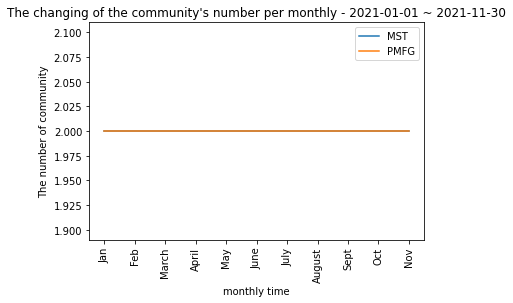

In [210]:
#plot
plt.plot(title, community_diff_monthly, label = "MST")
plt.plot(title,community_diff_monthly_pmfg, label = "PMFG")
plt.xlabel("monthly time")
plt.ylabel("The number of community")
plt.title("The changing of the community's number per monthly - 2021-01-01 ~ 2021-11-30")
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

### Calculte community of weekly data: 4.12-6.14, 8.16- 10.17 

#### 4.12-6.13

In [239]:
# load corresponding correlation matrix
cm_weekly_4_6 = np.load('../cm_data/0412_0615_1W_3h.npy', allow_pickle=True)
cm_weekly_8_10 = np.load('../cm_data/0816_1018_1W_3h.npy', allow_pickle=True)

In [241]:
# load corresponding name lists
import json
 
# Opening JSON file
f_1 = open('../cm_data/0412_0615_1W_3h_namelist.json')
name_list_weekly_4_6 = json.load(f_1)
 
f_2 = open('../cm_data/0816_1018_1W_3h_namelist.json')
name_list_weekly_8_10 = json.load(f_2)
# Closing file
f_1.close()
f_2.close()


In [253]:
def build_community_graphs(cm, g_func, name_lists, title, save_path, g_type, position_set):
    # Save community graphs of MST
    community_diff = []
    for i in range(0, len(cm)):

        g = g_func(cm[i], False)
        #Calculate community
        communities_generator = community.girvan_newman(g)
        top_level_communities = next(communities_generator)
        community_diff.append(len(top_level_communities))

        node_groups = []
        for com in top_level_communities:
            node_groups.append(list(com))
        #print(node_groups)

        nodenames = {}
        for j in range(0, len(name_lists[i])):
            value = name_lists[i][j]
            nodenames[j] = value
        #print(nodenames)
        nx.set_node_attributes(g, nodenames, 'ticker')

        map_pos = {}
        for k in range(0, len(name_lists[i])):
            coin = name_lists[i][k]
            pos_coin = position_set[coin]
            map_pos[k] = pos_coin
        
        nw_plot(g, node_groups, title[i], save_path, g_type, map_pos)
    
    return community_diff

In [243]:
def assign_position(cm_list, name_lists, func):
  position_set = {}
  g_0 = func(cm_list[0], False)
  pos_0 = nx.spring_layout(g_0)
  #print(pos_0)
  for i in range(0, len(name_lists[0])):
    position_set[name_lists[0][i]] = pos_0[i]

  for j in range(1, len(cm_list)):
    g = func(cm_list[j], False)
    pos = nx.spring_layout(g)
    next_coins = name_lists[j]
    current_coins = position_set.keys()
    new_add_coins = list(set(next_coins) - set(current_coins))
    for k in range(0, len(new_add_coins)):
      idx = next_coins.index(new_add_coins[k])
      current_pos = pos[idx]
      position_set[new_add_coins[k]] = current_pos
    #print(len(position_set))
  return position_set

In [244]:
def create_time_title(date_range):
    title = []
    for i in range(0, len(date_range)-1):
        temp = date_range[i] + " ~ " + date_range[i + 1]
        title.append(temp)

    return title

In [245]:
# build position map
pos_weekly_4_6_mst = assign_position(cm_weekly_4_6, name_list_weekly_4_6, MST)
pos_weekly_4_6_pmfg = assign_position(cm_weekly_4_6, name_list_weekly_4_6, PMFG)

In [ ]:
date_range = pd.date_range(start="2021-04-12",end="2021-06-15", freq='7D').strftime('%Y-%m-%d')
title = create_time_title(date_range)
#print(len(title))
community_diff_4_6_mst = build_community_graphs(cm_weekly_4_6, MST, name_list_weekly_4_6, title, '../plots/weekly/4_6/mst', 'MST', pos_weekly_4_6_mst)
community_diff_4_6_pmfg = build_community_graphs(cm_weekly_4_6, PMFG, name_list_weekly_4_6, title, '../plots/weekly/4_6/pmfg', 'PMFG', pos_weekly_4_6_pmfg)

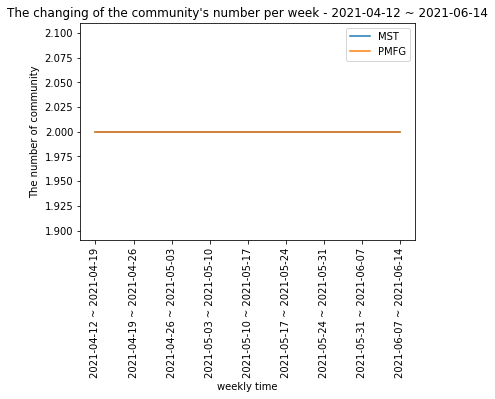

In [256]:
# plot the changes of the number of community
plt.plot(title, community_diff_4_6_mst, label = "MST")
plt.plot(title,community_diff_4_6_pmfg, label = "PMFG")
plt.xlabel("weekly time")
plt.ylabel("The number of community")
plt.title("The changing of the community's number per week - 2021-04-12 ~ 2021-06-14")
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

#### 8.16-10.18


In [257]:
# build position map
pos_weekly_8_10_mst = assign_position(cm_weekly_8_10, name_list_weekly_8_10, MST)
pos_weekly_8_10_pmfg = assign_position(cm_weekly_8_10, name_list_weekly_8_10, PMFG)

In [ ]:
date_range = pd.date_range(start="2021-08-16",end="2021-10-18", freq='7D').strftime('%Y-%m-%d')
title = create_time_title(date_range)
#print(len(title))
community_diff_8_10_mst = build_community_graphs(cm_weekly_8_10, MST, name_list_weekly_8_10, title, '../plots/weekly/8_10/mst', 'MST', pos_weekly_8_10_mst)
community_diff_8_10_pmfg = build_community_graphs(cm_weekly_8_10, PMFG, name_list_weekly_8_10, title, '../plots/weekly/8_10/pmfg', 'PMFG', pos_weekly_8_10_pmfg)

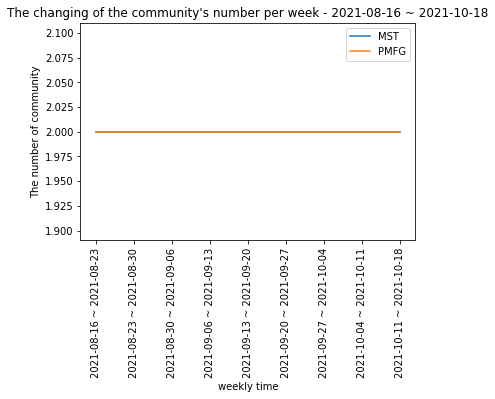

In [259]:
# plot the changes of the number of community
plt.plot(title, community_diff_8_10_mst, label = "MST")
plt.plot(title,community_diff_8_10_pmfg, label = "PMFG")
plt.xlabel("weekly time")
plt.ylabel("The number of community")
plt.title("The changing of the community's number per week - 2021-08-16 ~ 2021-10-18")
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

### Calculte community of daily data: 4.12-6.14, 8.16 - 10.17

In [ ]:
# load correlation matrics
cm_daily_4_6 = np.load('../cm_data/0412_0615_1d_30m.npy', allow_pickle=True)
cm_daily_8_10 = np.load('../cm_data/0816_1018_1d_30m.npy', allow_pickle=True)

In [ ]:
# load name lists
 
# Opening JSON file
f_1 = open('../cm_data/0412-0615_1d_30m_namelist.json')
name_list_daily_4_6 = json.load(f_1)
 
f_2 = open('../cm_data/0816-1018_1d_30m_namelist.json')
name_list_daily_8_10 = json.load(f_2)
# Closing file
f_1.close()
f_2.close()

In [ ]:
print(len(cm_daily_8_10))
print(len(name_list_daily_8_10))

63
63


#### 4.12 - 6.14


In [260]:
# build position map
pos_daily_4_6_mst = assign_position(cm_daily_4_6, name_list_daily_4_6, MST)
pos_daily_4_6_pmfg = assign_position(cm_daily_4_6, name_list_daily_4_6, PMFG)

In [ ]:
date_range = pd.date_range(start="2021-04-12",end="2021-06-14", freq='D').strftime('%Y-%m-%d')
print(len(date_range))
community_diff_4_6_mst = build_community_graphs(cm_daily_4_6, MST, name_list_daily_4_6, date_range, '../plots/daily/4_6/mst', 'MST',pos_daily_4_6_mst)
community_diff_4_6_pmfg = build_community_graphs(cm_daily_4_6, PMFG, name_list_daily_4_6, date_range, '../plots/daily/4_6/pmfg', 'PMFG', pos_daily_4_6_pmfg)

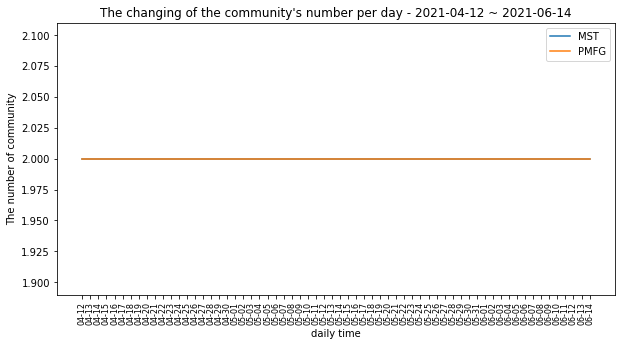

In [262]:
#plot 
x = pd.date_range(start="2021-04-12",end="2021-06-14", freq='D').strftime('%m-%d')
fig = plt.figure(figsize = (10,5))
plt.plot(x, community_diff_4_6_mst, label = "MST")
plt.plot(x,community_diff_4_6_pmfg, label = "PMFG")
plt.xlabel("daily time")
plt.ylabel("The number of community")
plt.title("The changing of the community's number per day - 2021-04-12 ~ 2021-06-14")
plt.legend()
plt.xticks(rotation='vertical', fontsize=8)
plt.show()

#### 8.16-10.18

In [263]:
# build position map
pos_daily_8_10_mst = assign_position(cm_daily_8_10, name_list_daily_8_10, MST)
pos_daily_8_10_pmfg = assign_position(cm_daily_8_10, name_list_daily_8_10, PMFG)

In [ ]:
date_range = pd.date_range(start="2021-08-16",end="2021-10-18", freq='D').strftime('%Y-%m-%d')
print(len(date_range))
community_diff_8_10_mst = build_community_graphs(cm_daily_8_10, MST, name_list_daily_8_10, date_range, '../plots/daily/8_10/mst', 'MST', pos_daily_8_10_mst)
community_diff_8_10_pmfg = build_community_graphs(cm_daily_8_10, PMFG, name_list_daily_8_10, date_range, '../plots/daily/8_10/pmfg', 'PMFG', pos_daily_8_10_pmfg)

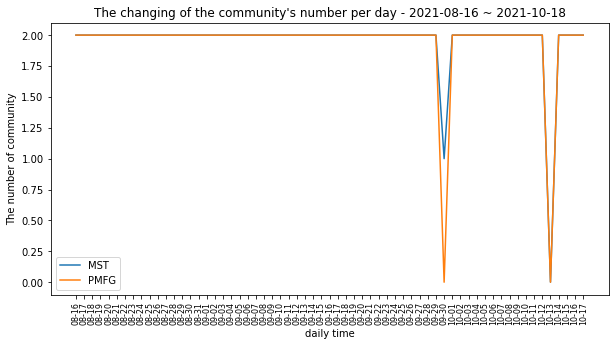

In [265]:
#plot 
x = pd.date_range(start="2021-08-16",end="2021-10-17", freq='D').strftime('%m-%d')
fig = plt.figure(figsize = (10,5))
plt.plot(x, community_diff_8_10_mst, label = "MST")
plt.plot(x, community_diff_8_10_pmfg, label = "PMFG")
plt.xlabel("daily time")
plt.ylabel("The number of community")
plt.title("The changing of the community's number per day - 2021-08-16 ~ 2021-10-18")
plt.legend()
plt.xticks(rotation='vertical', fontsize=8)
plt.show()

### Calculte community of monthly data: 2020-12 ~ 2021-11

In [267]:
# load corresponding correlation matrix
cm_monthly = np.load('../cm_data/12_11_M_1d.npy', allow_pickle=True)

In [268]:
# load corresponding name lists
 
# Opening JSON file
f = open('../cm_data/12_11_M_1d_namelist.json')
name_list_monthly = json.load(f)
 
# Closing file
f.close()

In [269]:
# build position map
pos_monthly_mst = assign_position(cm_monthly, name_list_monthly, MST)
pos_monthly_pmfg = assign_position(cm_monthly, name_list_monthly, PMFG)

In [ ]:
title = ['Dec','Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'Sept', 'Oct', 'Nov']
community_monthly_mst = build_community_graphs(cm_monthly, MST, name_list_monthly, title, '../plots/monthly/mst', 'MST', pos_monthly_mst)
community_monthly_pmfg = build_community_graphs(cm_monthly, PMFG, name_list_monthly, title, '../plots/monthly/pmfg', 'PMFG', pos_monthly_pmfg)

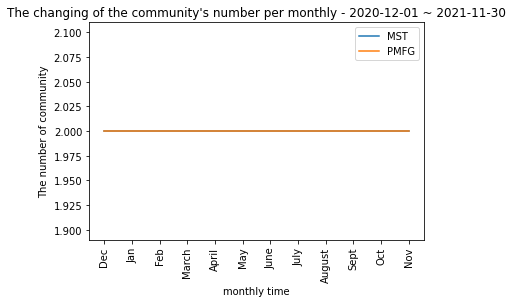

In [271]:
#plot
plt.plot(title, community_monthly_mst, label = "MST")
plt.plot(title,community_monthly_pmfg, label = "PMFG")
plt.xlabel("monthly time")
plt.ylabel("The number of community")
plt.title("The changing of the community's number per monthly - 2020-12-01 ~ 2021-11-30")
plt.legend()
plt.xticks(rotation='vertical')
plt.show()